In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.optimize import curve_fit
from math import floor, log10
#df = pd.read_csv('SimplestClean15sigma/131125_darkrate_1750_10000_1_off_clean.csv')

In [16]:
"""
Cleaned CSV has columns:

            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'FWHM': all_FWHM,
            't1_of_FWHM': all_t1,
            't2_of_FWHM': all_t2,
            'time_above_15sigma': all_time_above_15thresh,
            'first_15sigma_crossing': all_first_15crossing,
            'second_15sigma_crossing': all_second_15crossing,
            'time_above_10sigma': all_time_above_10thresh,
            'first_10sigma_crossing': all_first_10crossing,
            'second_10sigma_crossing': all_second_10crossing,
            'time_above_5sigma': all_time_above_5thresh,
            'first_5sigma_crossing': all_first_5crossing,
            'second_5sigma_crossing': all_second_5crossing,
            'integral_pC': all_integrals_picocharge,
            'peaks_over_15sigma_threshold': number_of_maxima_all,
            'event_timestamps' : event_timestamps[:-1]
"""

"\nCleaned CSV has columns:\n\n            'baseline': mean_b_array,\n            'sd_baseline': sigma_b_array,\n            'amplitude': all_amplitudes,\n            'peak_time': all_peak_times,\n            'FWHM': all_FWHM,\n            't1_of_FWHM': all_t1,\n            't2_of_FWHM': all_t2,\n            'time_above_15sigma': all_time_above_15thresh,\n            'first_15sigma_crossing': all_first_15crossing,\n            'second_15sigma_crossing': all_second_15crossing,\n            'time_above_10sigma': all_time_above_10thresh,\n            'first_10sigma_crossing': all_first_10crossing,\n            'second_10sigma_crossing': all_second_10crossing,\n            'time_above_5sigma': all_time_above_5thresh,\n            'first_5sigma_crossing': all_first_5crossing,\n            'second_5sigma_crossing': all_second_5crossing,\n            'integral_pC': all_integrals_picocharge,\n            'peaks_over_15sigma_threshold': number_of_maxima_all,\n            'event_timestamps' : ev

In [17]:
#find the difference between the first timestamp and final timestamp
#timestamp_column = df['event_timestamps']
#timetaken = timestamp_column.iloc[-1] - timestamp_column.iloc[0]

#amplitude_column = df['amplitude'] # using amplitude arbitrarily as data set includes all valuable data and each column in same length

#dark_rate = len(amplitude_column) / timetaken
#print(dark_rate)

In [18]:
"""
Need to find an average over three trials.
Some trials end up having very low numbers of events (super noisy data collection), these shouldn't be considered.
Need to plot dark rate against voltage. 
Try using the naming convention to loop over events and plot them? 

Name: date+note+voltage+10000+trialnumber+lights+clean.csv

"""

"\nNeed to find an average over three trials.\nSome trials end up having very low numbers of events (super noisy data collection), these shouldn't be considered.\nNeed to plot dark rate against voltage. \nTry using the naming convention to loop over events and plot them? \n\nName: date+note+voltage+10000+trialnumber+lights+clean.csv\n\n"

In [19]:
#15sigma threshold

#eliminate files with less than 1000 events in after cleaning.

#allfiles = glob.glob('PMT2_cleaned/*cleaned.csv')
#allfiles = glob.glob('ProcessedPMT2/*3.csv')
allfiles = glob.glob('PMT4_Cleaned_NoBaselineCut/*cleaned.csv')
enough_events = []

for f in allfiles:
    df = pd.read_csv(f)
    if len(df)<1000:
        print(f"Discarding {f}, only {len(df)} events after cleaning")
        continue
    enough_events.append(f)



Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1750_10000_2_off_processed_threshold11_cleaned.csv, only 173 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1800_10000_3_on_processed_threshold11_cleaned.csv, only 152 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1850_10000_2_off_processed_threshold11_cleaned.csv, only 47 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1850_10000_2_on_processed_threshold11_cleaned.csv, only 3 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1850_10000_3_on_processed_threshold11_cleaned.csv, only 2 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1900_10000_1_on_processed_threshold11_cleaned.csv, only 22 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrate_1900_10000_2_on_processed_threshold11_cleaned.csv, only 242 events after cleaning
Discarding PMT4_Cleaned_NoBaselineCut\220126_darkrat

In [20]:
#15sigma threshold

# first find the place value of the smallest digit in the timesteps:
def last_digit_place_value(x):
    """
    Returns the place value of the last digit in x.
    Example: 0.1234 -> 0.0001, 15.20 -> 0.01, 5000 -> 1000
    """
    s = str(x)

    # Handle scientific notation
    if 'e' in s.lower():
        s = format(float(x), '.15f').rstrip('0').rstrip('.')

    if '.' in s:
        frac_part = s.split('.')[1]
        return 10 ** (-len(frac_part))
    else:
        trailing_zeros = len(s) - len(s.rstrip('0'))
        return 10 ** trailing_zeros
    
#calculate dark rate for each csv in enough_events and their errors
dark_rates = {}
for file in enough_events:
    df = pd.read_csv(file)
    timestamp_column = df['event_timestamps']
    timetaken = timestamp_column.iloc[-1] - timestamp_column.iloc[0]

    amplitude_column = df['amplitude']

    dark_rate = len(amplitude_column) / timetaken

# calculate errors
    N = len(amplitude_column)
    t_last_err = 0.5 * last_digit_place_value(timestamp_column.iloc[-1])
    t_first_err = 0.5 * last_digit_place_value(timestamp_column.iloc[0])
    t_err = np.sqrt(t_last_err**2 + t_first_err**2)

    #DR_err = np.sqrt(N)
    DR_err = np.sqrt((np.sqrt(N)/timetaken)**2 + ((N*t_err)/timetaken**2)**2)
    #DR_err = np.sqrt((np.sqrt(N)/timetaken)**2 + ((N*t_err)/timetaken**2)**2 +(0.05*dark_rate)**2)
    print(DR_err)

# disregard dark rate value out of average if an anomaly
    if dark_rate > 3000: 
        print(f"Discarding {file} due to unusual dark rate = {dark_rate:.3f}Hz")
        continue



    dark_rates[file] = (dark_rate, DR_err)
    print(f"{file} has dark rate = {dark_rate:.3f} Hz")
    print(f"{file} ",'amount of events in clean files', len(amplitude_column))

#PUT ERROR PROPAGATION HERE FOR EACH RATE

0.2869469872695466
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1750_10000_1_on_processed_threshold11_cleaned.csv has dark rate = 21.431 Hz
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1750_10000_1_on_processed_threshold11_cleaned.csv  amount of events in clean files 5578
0.4783794929124018
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1750_10000_3_on_processed_threshold11_cleaned.csv has dark rate = 19.123 Hz
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1750_10000_3_on_processed_threshold11_cleaned.csv  amount of events in clean files 1598
0.7100270833327701
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1800_10000_1_off_processed_threshold11_cleaned.csv has dark rate = 59.845 Hz
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1800_10000_1_off_processed_threshold11_cleaned.csv  amount of events in clean files 7104
0.5044659350559157
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1800_10000_1_on_processed_threshold11_cleaned.csv has dark rate = 44.001 Hz
PMT4_Cleaned_NoBaselineCut\220126_darkrate_1800_10000

<>:152: SyntaxWarning: invalid escape sequence '\p'
<>:164: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\c'
<>:152: SyntaxWarning: invalid escape sequence '\p'
<>:164: SyntaxWarning: invalid escape sequence '\p'
<>:177: SyntaxWarning: invalid escape sequence '\c'
C:\Users\holly\AppData\Local\Temp\ipykernel_41140\3859489380.py:152: SyntaxWarning: invalid escape sequence '\p'
  return f"{val:.1e} \pm {err:.1e}"
C:\Users\holly\AppData\Local\Temp\ipykernel_41140\3859489380.py:164: SyntaxWarning: invalid escape sequence '\p'
  return (f"({scaled_val:.{n}f} \pm {scaled_err:.{n}f}) "
C:\Users\holly\AppData\Local\Temp\ipykernel_41140\3859489380.py:177: SyntaxWarning: invalid escape sequence '\c'
  label += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu, n=2)}'


20.277070938912246
0.27892002112711267
38.76348434327291
0.32427020346410196
549.9922560031733
5.564568843747991
543.7352087500587
5.698641434226029
272.35761237951897
2.175566729356533
2588.712827262684
27.08653000140206
100.21506177589724
286.9074412114282
812.5225219319191
212.19035939576986
2572.9175794278112
1750 V : combined dark rate = 2.028e+01 ± 2.789e-01 Hz
1800 V : combined dark rate = 6.949e+01 ± 3.893e-01 Hz
1850 V : combined dark rate = 4.184e+02 ± 4.234e+00 Hz
1900 V : combined dark rate = 6.781e+02 ± 4.148e+00 Hz
1950 V : combined dark rate = 2.423e+02 ± 1.540e+00 Hz
2000 V : combined dark rate = 2.581e+03 ± 1.909e+01 Hz


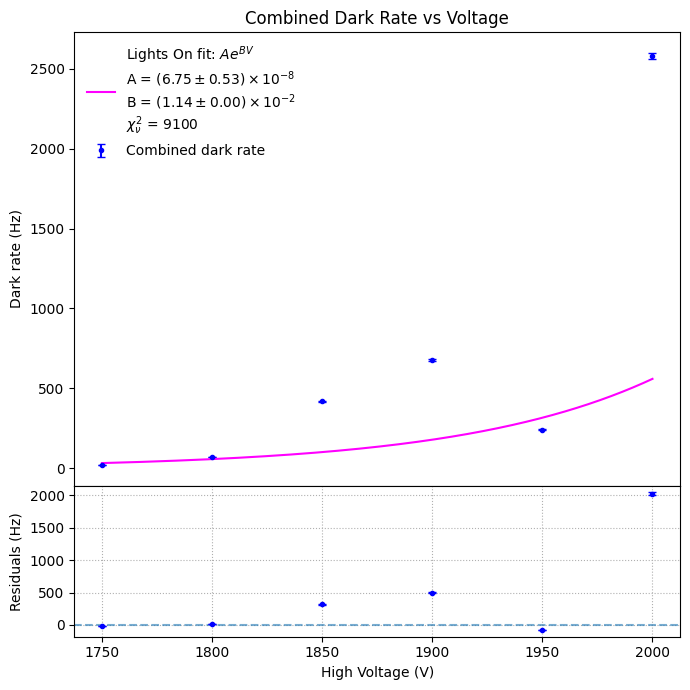


Chi² = 3.649e+04
DoF = 4
Reduced Chi² = 9.123e+03


In [ ]:
#15sigma threshold
#plot dark rate against voltage for lights on and lights off on the same plot.

#these will be lists of voltages with their corresponding dark rates. eg. {1750: [213,453,241], 2000: [542,622,315]}
lights_on = {} 
lights_off = {}

for file, (darkrate, DR_err) in dark_rates.items():
    df = pd.read_csv(file)
    #extract voltage, trial number and light on/off from filename
    match = re.search(r"darkrate_(\d+)_10000_(\d+)_(on|off)", file)

    voltage = int(match.group(1))
    trial_number = int(match.group(2))
    light_state = match.group(3)

    #store light state.
    if light_state == 'on':
        lights_on.setdefault(voltage,[]).append((darkrate, DR_err))
    if light_state == 'off':
        lights_off.setdefault(voltage,[]).append((darkrate, DR_err))

#average trials for each voltage
#ADD ERROR ON MEAN AND PUT IN PLOT
for voltage, rate_list in lights_on.items():
    rate, err= zip(*rate_list)
    
    rate = np.array(rate)
    err = np.array(err)

    valid_mask = (err > 0) & np.isfinite(err) & np.isfinite(rate) 
    valid_rate = rate[valid_mask]
    valid_err = err[valid_mask]
    # use a weighted mean
    x = len(valid_rate)
    weights = 1 / (valid_err**2)
    mean_rate = np.sum(weights * valid_rate) / np.sum(weights)
    mean_err = np.sqrt(1 / np.sum(weights))
    #mean_rate = sum(valid_rate)/len(valid_rate)
    #mean_err = np.sqrt((1/x)**2 * np.sum((valid_err**2))) # combine in quadrature
    lights_on[voltage] = (mean_rate, mean_err) #replace the list with a single average rate element
    print(mean_rate)
    print(mean_err)

for voltage, rate_list in lights_off.items():
    rate, err= zip(*rate_list)
   
    rate = np.array(rate)
    err = np.array(err)

    valid_mask = (err > 0) & np.isfinite(err) & np.isfinite(rate) 
    valid_rate = rate[valid_mask]
    valid_err = err[valid_mask]

    x = len(valid_rate)
    mean_rate = sum(valid_rate)/len(valid_rate)
    mean_err = np.sqrt((1/x)**2 * np.sum((valid_err**2))) 
    lights_off[voltage] = (mean_rate, mean_err)
    print(mean_rate)

voltages_on = sorted(lights_on.keys())
average_rate_on = [lights_on[v][0] for v in voltages_on]
average_err_on = [lights_on[v][1] for v in voltages_on]
voltages_off = sorted(lights_off.keys())
average_rate_off = [lights_off[v][0] for v in voltages_off]
average_err_off = [lights_off[v][1] for v in voltages_off]

combined_dark = {}

all_voltages = sorted(set(lights_on.keys()) | set(lights_off.keys()))

for V in all_voltages:
    values = []
    errors = []

    if V in lights_on:
        r, e = lights_on[V]
        if np.isfinite(r) and np.isfinite(e) and e > 0:
            values.append(r)
            errors.append(e)

    if V in lights_off:
        r, e = lights_off[V]
        if np.isfinite(r) and np.isfinite(e) and e > 0:
            values.append(r)
            errors.append(e)

    values = np.array(values)
    errors = np.array(errors)

    mean = np.mean(values)
    err = np.sqrt(np.sum(errors**2)) / len(values)

    combined_dark[V] = (mean, err)

    print(f"{V} V : combined dark rate = {mean:.3e} ± {err:.3e} Hz")

voltages = np.array(sorted(combined_dark.keys()))
rates = np.array([combined_dark[V][0] for V in voltages])
errors = np.array([combined_dark[V][1] for V in voltages])


def exponential_C(V, A, B, C):
    return A * np.exp(B * V) + C

def exponential(V, A, B):
    return A * np.exp(B * V)

def linear(V, m, c):
    return m*V + c

mask = np.isfinite(rates) & np.isfinite(errors) & (errors > 0)
V_fit = voltages[mask]
R_fit = rates[mask]
E_fit = errors[mask]

popt, pcov = curve_fit(
    exponential,
    V_fit,
    R_fit,
    sigma=E_fit,
    absolute_sigma=True,
    p0=[1, 0.01]
)

perr = np.sqrt(np.diag(pcov))

V_dense = np.linspace(np.min(V_fit), np.max(V_fit), 1000)
R_dense = exponential(V_dense, *popt)

residuals = R_fit - exponential(V_fit, *popt)

chi2 = np.sum((residuals / E_fit)**2)
nu = len(V_fit) - len(popt)

chi2nu = chi2 / nu

def fmt_sig_figs(val, n=2):
    """Rounds a number to n significant figures and returns as a string."""
    if val == 0:
        return "0"
    # Calculate the order of magnitude
    mag = floor(log10(abs(val)))
    # Round to the appropriate decimal place
    rounded_val = round(val, -int(mag - (n - 1)))
    # Format as a float to avoid scientific notation in the string
    return f"{rounded_val:g}"

def format_scientific_latex(val, err, n=2):
    """
    Formats a value and error into LaTeX scientific notation 
    sharing the same power of 10.
    """
    if err <= 0:
        return f"{val:.1e} \pm {err:.1e}"

    # 1. Find the exponent of the value
    exponent = floor(log10(abs(val)))
    
    # 2. Scale both by that exponent
    factor = 10**exponent
    scaled_val = val / factor
    scaled_err = err / factor
    
    # 3. Return the LaTeX string
    # n controls decimal places (e.g., n=2 gives 1.23)
    return (f"({scaled_val:.{n}f} \pm {scaled_err:.{n}f}) "
            f"\\times 10^{{{exponent}}}")

if popt is not None:
    a_tex = format_scientific_latex(popt[0], perr[0], n=2)
    b_tex = format_scientific_latex(popt[1], perr[1], n=2)
    
    label = (
        r'Lights On fit: $A e^{BV}$' +
        f'\nA = ${a_tex}$' +
        f'\nB = ${b_tex}$'
    )
    if chi2nu is not None:
        label += f'\n$\chi^2_\\nu$ = {fmt_sig_figs(chi2nu, n=2)}'


fig, (ax_main, ax_res) = plt.subplots(2, 1, sharex=True, figsize=(7,7),
                                     gridspec_kw={'height_ratios':[3,1],'hspace':0})

ax_main.errorbar(V_fit, R_fit, yerr=E_fit, fmt='o', ms=3, color='b', capsize=3, label="Combined dark rate")
ax_main.plot(V_dense, R_dense, '-', color='magenta', label=label)

ax_main.set_ylabel("Dark rate (Hz)")
ax_main.set_title("Combined Dark Rate vs Voltage")
ax_main.legend(frameon=False)
ax_main.tick_params(axis='x', labelbottom=False)

residuals = R_fit - exponential(V_fit, *popt)

ax_res.axhline(0, ls="--", alpha=0.6)
ax_res.errorbar(V_fit, residuals, yerr=E_fit, fmt='o', color='b', ms=3, capsize=3)
ax_res.set_xlabel("High Voltage (V)")
ax_res.set_ylabel("Residuals (Hz)")
ax_res.grid(True, linestyle=":")

plt.tight_layout()
plt.show()

chi2 = np.sum((residuals / E_fit)**2)
nu = len(V_fit) - len(popt)

print(f"\nChi² = {chi2:.3e}")
print(f"DoF = {nu}")
print(f"Reduced Chi² = {chi2/nu:.3e}")